In [1]:
import copy
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#求解Pn~Pm
PN = 1.472927  #expterm = 8.233506606
PM = 1.924981 
#求解Rn~Rm
RN = 0.2229268029
RM = 0.3374904595

def generate_equidistant_array(min_val, max_val, m):
    if m <= 1:
        return [min_val] * m
    
    step = (max_val - min_val) / (m - 1)
    equidistant_array = [min_val + i * step for i in range(m)]
    
    return equidistant_array

# 定价空间计算
# 空间离散数量
m = 15
PRICING_SPACE = generate_equidistant_array((PN-0.1*(PM-PN)), (PM+0.1*(PM-PN)), m)
# 罚款空间计算
# 空间离散数量
k = 10
PENALTY_SPACE = generate_equidistant_array(0, 2*(RM-RN), k)
print(PRICING_SPACE)
print(PENALTY_SPACE)

[1.4277216000000001, 1.466469085714286, 1.5052165714285715, 1.5439640571428572, 1.582711542857143, 1.6214590285714288, 1.6602065142857143, 1.698954, 1.7377014857142858, 1.7764489714285716, 1.8151964571428572, 1.853943942857143, 1.8926914285714287, 1.9314389142857142, 1.9701864]
[0.0, 0.025458590355555557, 0.050917180711111114, 0.07637577106666667, 0.10183436142222223, 0.12729295177777777, 0.15275154213333333, 0.1782101324888889, 0.20366872284444446, 0.22912731320000002]


In [3]:
class Pricing_Agent:
    def __init__(self, alpha=0.2, gamma=0.98, beta=0.000005, action_space = PRICING_SPACE):
        """
        代理类，代表一个企业。
        参数:
            alpha (float): 学习率。
            beta (float): epsilon的消散比率
            gamma (float): 未来奖励的折扣因子。
            action_space (list): 定价空间
        """
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.action_space = action_space  # 策略空间
        self.q_matrix = {}      #用字典的形式存储Q-matrix
        for possible_prices in itertools.product(PRICING_SPACE, repeat=2):   
            for possible_penalty in PENALTY_SPACE:    #遍历笛卡尔积，即状态空间是双方的可能价格*罚金 m*m*k
                possible_state = (possible_prices,possible_penalty)
                self.q_matrix[possible_state] = dict((price, 0.0) for price in action_space)       #每个定价（行动）的初始值为0

    def choose_action(self, state, t):
        """
        根据当前状态和时间步选择行动（价格）/选择是explore还是exploit
        参数:
            opponent_price (float): 对手的价格。
            t (int): 当前时间步。
        返回:
            float: 选择的价格。
        """
        epsilon = np.exp(-self.beta * t)
        if np.random.random() < epsilon:
            # explore：随机选择一个价格
            return np.random.choice(self.action_space)
        else:
            return self.get_optimal_action(state)
        
    def get_optimal_action(self,state):
        """
        根据Q-matrix和现在的state选择最优行动
        """
        optimal_actions = [
            action for action, value in self.q_matrix[state].items() if value == max(self.q_matrix[state].values())
            #获取最大qvalue对应的action，若有多个则随机选择
        ]
        return random.choice(optimal_actions)

    def update_q_table(self, state, action, reward, next_state):
        """
        更新Q表。
        参数:
            state (tuple): 双方上一期的价格。
            action (float): 本期的价格决策。
            reward (float): 本期的奖励。
            next_state (tuple): 本期结束双方的价格。
        """
        state_action_value = copy.deepcopy(self.q_matrix[state][action])
        future_next_state_action_value = self.q_matrix[next_state][self.get_optimal_action(next_state)]
        self.q_matrix[state][action] = (1 - self.alpha) * state_action_value + self.alpha * (
                                        reward + self.gamma * future_next_state_action_value)

In [4]:
class Regulator:
    def __init__(self, alpha=0.2, gamma=0.98, beta=0.000005, action_space = PENALTY_SPACE):
        """
        监管者类，在市场中对算法合谋行为进行自动监管
        参数:
            alpha (float): 学习率。
            beta (float): epsilon的消散比率
            gamma (float): 未来奖励的折扣因子。
            action_space (list): 罚款空间
        """
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.action_space = list(itertools.product(action_space, repeat=2))  # 策略空间
        self.q_matrix = {}      #用字典的形式存储Q-matrix
        for possible_state in itertools.product(PRICING_SPACE, repeat=2):   #遍历笛卡尔积，即状态空间是双方的可能价格 m*m
            self.q_matrix[possible_state] = dict((penalty_pairs, 0.0) for penalty_pairs in self.action_space)       #每个定价（行动）的初始值为0

    def choose_action(self, state, t):
        """
        根据当前状态和时间步选择行动（价格）/选择是explore还是exploit
        参数:
            opponent_price (float): 对手的价格。
            t (int): 当前时间步。
        返回:
            tuple: 对每个厂商收取的罚金
        """
        epsilon = np.exp(-self.beta * t)
        if np.random.random() < epsilon:
            # explore：随机选择一个价格
            return random.choice(self.action_space)
        else:
            return self.get_optimal_action(state)
        
    def get_optimal_action(self,state):
        """
        根据Q-matrix和现在的state选择最优行动
        """
        optimal_actions = [
            action for action, value in self.q_matrix[state].items() if value == max(self.q_matrix[state].values())
            #获取最大qvalue对应的action，若有多个则随机选择
        ]
        return random.choice(optimal_actions)

    def update_q_table(self, state, action, reward, next_state):
        """
        更新Q表。
        参数:
            state (tuple): 本期双方的价格决策。
            action (tuple): 监管者对合谋收取的罚金。
            reward (float): 本期的消费者剩余。
            next_state (tuple): 下一期双方的定价决策。
        """
        state_action_value = copy.deepcopy(self.q_matrix[state][action])
        future_next_state_action_value = self.q_matrix[next_state][self.get_optimal_action(next_state)]
        self.q_matrix[state][action] = (1 - self.alpha) * state_action_value + self.alpha * (
                                        reward + self.gamma * future_next_state_action_value)

In [5]:
def calculate_demand(prices, a=2, mu=0.25):
    """
    根据multinomial loGIt模型计算需求。
    参数:
    prices (list): 所有公司的价格列表。
    返回:
    demands (list): 每个公司的需求列表。
    """
    n = len(prices)
    qualities = [a]*n
    exp_terms = np.array([((qualities[i] - prices[i] )/ mu) for i in range(n)])
    denominator = 1 + np.sum(np.exp(exp_terms))
    demands = np.exp(exp_terms) / denominator
    # print('双方的需求为：',demands)
    return demands

def calculate_profit(prices,c=1):
    """
    计算每个公司的利润。
    参数:
    prices (list): 所有公司的价格列表。
    返回:
    profits (list): 每个公司的利润列表。
    """  
    costs = [c]*len(prices)
    demands = calculate_demand(prices)
    profits = [(prices[i] - costs[i]) * demands[i] for i in range(len(prices))]
    return profits

def calculate_penalty(penalty,profits,mode = 0):
    """
    计算每个厂商被收取罚金之后的利润
    参数：
    penalty (tuple)：regulator输出的罚金
    profits (list)：每个厂商的原始利润
    mode (int)：
    """
    if mode == 0:
        rewards_after_penalty = profits
    else:
        # 计算每个对应元素的差
        rewards_after_penalty = [(x - y) for x, y in zip(profits, penalty)]
    return  rewards_after_penalty

def calculate_consumer_walfare(prices, mu=0.25, a=2):
    """
    根据新的定价计算消费者福利
    参数：
    prices (tuple/list)：每个厂商的定价
    返回:
    walfare (float): 社会福利
    """
    new_list = [np.exp((a-x)/mu) for x in prices]
    sum_list = sum(new_list)
    walfare = mu * np.log(1+sum_list)  # np.log计算的是自然对数
    return walfare

In [6]:
class Market:
    def __init__(self, pricing_agents, regulator):
        self.agents = pricing_agents
        print('厂商数量为：',len(self.agents))
        self.regulator = regulator

    def simulation(self,end_episode=2000000):
        # 初始化
        agents = self.agents
        regulator = self.regulator
        prices_record = []
        penalties_record = []
        rewards_record = []
        walfare_record = []
        prices = (PRICING_SPACE[0],) * len(agents)
        penalties = (0,) * len(agents)
        walfare = 0
        # 开始循环
        for episode in tqdm(range(end_episode)):
            # 定价代理选择定价
            new_prices = [0,0]
            new_penalties = (0,0)
            for i in range(len(agents)):
                agent_action = agents[i].choose_action((prices,penalties[i]),episode)
                new_prices[i] = agent_action  # 更新价格
            new_prices = tuple(new_prices)
            
            # 计算销售利润
            profits = calculate_profit(new_prices)
            # 计算本期的消费者福利
            walfare = calculate_consumer_walfare(new_prices)

            # 消费者福利为上一期监管者的奖励，监管者进行学习
            regulator.update_q_table(prices,  # 上期价格
                                    penalties,    # 上期收取的罚金
                                    walfare,    # 本期的消费者福利，是上一期的奖励
                                    new_prices)    # 收取罚金后的定价
            
            # 收取罚金
            new_penalties = regulator.choose_action(new_prices,episode)
            # 计算扣除罚金后的实际利润
            rewards = calculate_penalty(new_penalties,profits,mode=0)

            # 定价代理进行学习
            for i in range(len(agents)):
                agents[i].update_q_table((prices,penalties[i]),   # 双方的价格，即状态
                                        new_prices[i],  # 自己的价格
                                        rewards[i],
                                        (new_prices,new_penalties[i]))
                
            # 记录本周期的数据
            prices_record.append(new_prices)
            penalties_record.append(new_penalties)
            rewards_record.append(rewards)
            walfare_record.append(walfare)
            prices = new_prices
            penalties = new_penalties
            
        return prices_record,penalties_record,rewards_record,walfare_record

In [7]:
def calculate_and_plot_averages(data, plot_name, chunk_size = 1000):
    # 确定数据类型
    is_float = isinstance(data[0], float)

    # 将数据转换为numpy数组
    if is_float:
        data_array = np.array(data)
    else:
        data_array = np.array(data, dtype=object)
    
    # 计算每1000个元素的平均值
    num_chunks = (len(data) + chunk_size - 1) // chunk_size  # 向上取整
    averages = []

    for i in range(num_chunks):
        chunk = data_array[i * chunk_size:(i + 1) * chunk_size]
        if is_float:
            avg = np.mean(chunk)
        else:
            avg = tuple(np.mean(chunk, axis=0))
        averages.append(avg)
    
    # 绘制折线图
    plt.figure(figsize=(10, 6))
    if is_float:
        plt.plot(averages, linestyle='-')
    else:
        for col in range(len(averages[0])):
            plt.plot([avg[col] for avg in averages], linestyle='-', label=f'Agent {col+1}')
        plt.legend()
        
    plt.ylabel('Average Values')
    plt.xlabel('Episodes (of 1000s)')
    plt.title(plot_name)
    plt.grid(True)
    plt.show()

In [8]:
agent1 = Pricing_Agent()
agent2 = Pricing_Agent()
regulator = Regulator()


In [9]:
market = Market([agent1,agent2],regulator)
prices_record,penalty_record,rewards_record,walfare_record = market.simulation()

厂商数量为： 2


100%|██████████| 2000000/2000000 [16:37<00:00, 2004.26it/s]


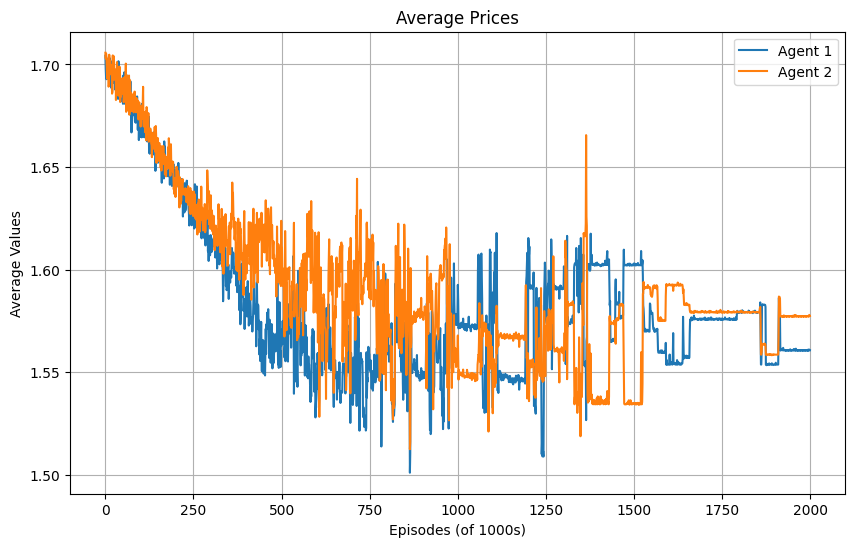

In [10]:
calculate_and_plot_averages(prices_record,'Average Prices')

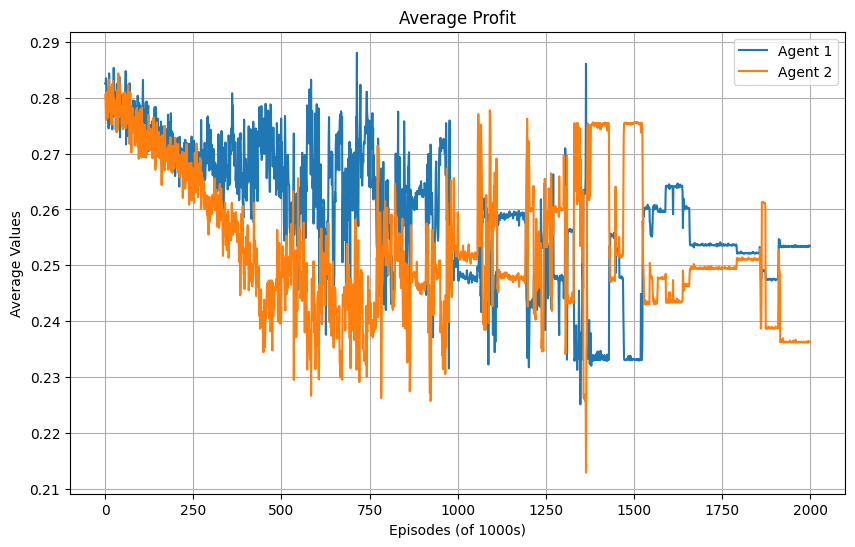

In [11]:
calculate_and_plot_averages(rewards_record,'Average Profit')

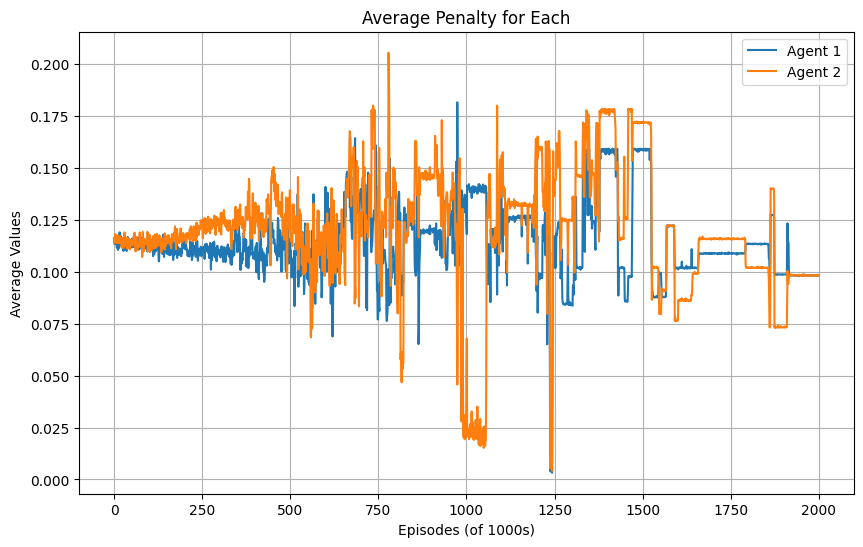

In [12]:
calculate_and_plot_averages(penalty_record,'Average Penalty for Each')

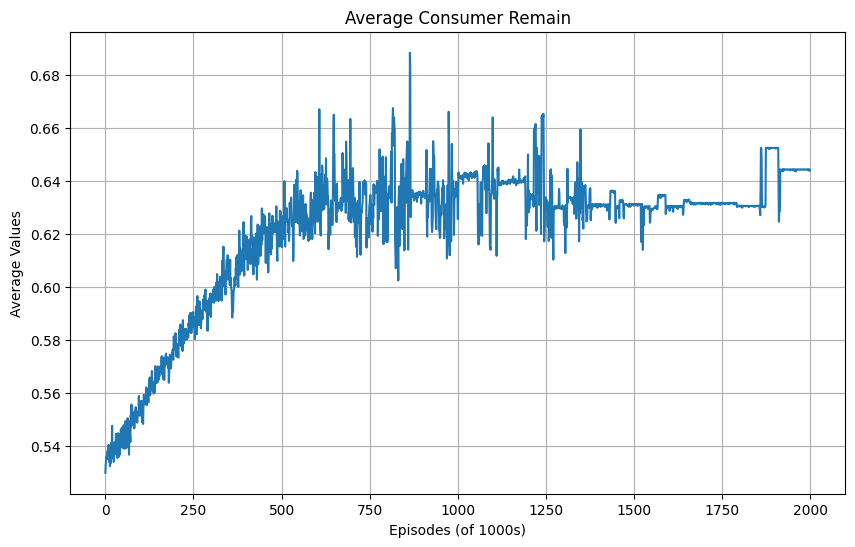

In [13]:
calculate_and_plot_averages(walfare_record,'Average Consumer Remain')